In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import math
from torchvision import models as torch_model
import numpy as np
import torch.nn as nn
import graphviz
from torchview import draw_graph
import os
from matplotlib import pyplot as plot
import time

In [2]:
batch_size = 128
epochs = 5
learning_rate = 0.001
num_classes = 10
dir_name = os.getcwd()
acc_array = []

In [3]:
def get_norm_params(dataset):
    mean = dataset.data.mean(axis=(0,1,2))/255
    std = dataset.data.std(axis=(0,1,2))/255
    return torch.tensor(mean).reshape(3, 1, 1), torch.tensor(std).reshape(3, 1, 1)

In [5]:
def get_data_loader(transforms_params):

   train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = transforms_params
)
   test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = transforms_params
)
   train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
  )

   test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False)
   return train_data_loader, test_data_loader

In [6]:
loss_function = torch.nn.CrossEntropyLoss()
print('Training parameters: learning rate = {}, batch size = {}, number of epochs = {}'.format(learning_rate, batch_size, epochs))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


Training parameters: learning rate = 0.001, batch size = 128, number of epochs = 5


device(type='cpu')

In [7]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [8]:
def train(Network, train_data_loader, test_data_loader, optimizer):
    for epoch in range(epochs):
        start = time.time()
        losses = []
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = Network(images)
            loss = loss_function(outputs, labels)
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        duration = time.time() - start
        print('Epoch[{}]: loss = {}, accuracy = {}, time = {}'.format(epoch, torch.stack(losses).mean(), get_accuracy(Network,train_data_loader, device), duration))
    acc = get_accuracy(Network,test_data_loader, device)
    print('Test accuracy: {}'.format(acc))
    return acc

In [9]:
def show_Network(Network):
  graphviz.set_jupyter_format('png')
  model_graph = draw_graph(Network, input_size=(1,3,32,32), expand_nested=True)
  model_graph.visual_graph

In [10]:
def FreezeLayers(Network, train_data_loader, test_data_loader, upd_layers):
  for params in Network.parameters():
    params.requires_grad = False
  Network.fc = torch.nn.Linear(Network.fc.in_features, upd_layers)
  return Network

In [11]:
def ModLastLAyers(Network, train_data_loader, test_data_loader, upd_layers):
    for params in Network.parameters():
     params.requires_grad = False
    Network.fc = torch.nn.Sequential(torch.nn.Linear(Network.fc.in_features, Network.fc.in_features//2), torch.nn.ReLU(), torch.nn.Linear(Network.fc.in_features//2, 10),)
    return Network

In [12]:
def get_first_ex(Network_type, weights):
  Network = Network_type(weights)
  transforms = weights.transforms()
  train_data_loader, test_data_loader = get_data_loader(transforms)
  Network.to(device)
  Network = FreezeLayers(Network, train_data_loader, test_data_loader, num_classes)
  Network.to(device)
  optimizer = torch.optim.Adam(Network.parameters(), lr = learning_rate)
  acc = train(Network, train_data_loader, test_data_loader, optimizer)
  print(Network)
  show_Network(Network)
  return acc

In [13]:
def get_second_ex(Network_type, weights):
  Network = Network_type(weights)
  transforms = weights.transforms()
  train_data_loader, test_data_loader = get_data_loader(transforms)
  Network = ModLastLAyers(Network, train_data_loader, test_data_loader, num_classes)
  Network.to(device)
  optimizer = torch.optim.Adam(Network.parameters(), lr = learning_rate)
  acc = train(Network, train_data_loader, test_data_loader, optimizer)
  print(Network)
  show_Network(Network)
  return acc

In [14]:
def show_exp_result(acc_array_, type_array_):
  results = {}
  for i in range(len(acc_array_)):
    results[type_array[i]] = acc_array[i].cpu()
  print(results)
  fig = plot.figure(figsize = (25, 6))
  plot.bar(results.keys(), results.values())
  plot.xlabel("Models experiments")
  plot.ylabel("Test accuracy")
  plot.title("Comparison of architectures modifications")
  for i in range(len(acc_array_)):
        plot.text(i, acc_array[i].cpu() + 0.01, f'{int(acc_array[i].cpu() * 100)} %', ha='center')
  plot.show()

In [15]:
acc_array.append(get_first_ex(torch_model.googlenet, torch_model.GoogLeNet_Weights.DEFAULT))

C:\Users\soup4\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 1.0498464107513428, accuracy = 0.7409200072288513, time = 2391.8952448368073
Epoch[1]: loss = 0.7557734251022339, accuracy = 0.754360020160675, time = 1842.29297041893
Epoch[2]: loss = 0.7154982089996338, accuracy = 0.7655400037765503, time = 1841.0229659080505
Epoch[3]: loss = 0.6931825280189514, accuracy = 0.765720009803772, time = 1840.9419713020325
Epoch[4]: loss = 0.6832707524299622, accuracy = 0.7699000239372253, time = 1843.7079682350159
Test accuracy: 0.7501999735832214
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2

In [16]:
acc_array.append(get_second_ex(torch_model.googlenet, torch_model.GoogLeNet_Weights.DEFAULT))

Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 1.054963231086731, accuracy = 0.7353799939155579, time = 1842.6800017356873
Epoch[1]: loss = 0.7587095499038696, accuracy = 0.7562999725341797, time = 1838.332030057907
Epoch[2]: loss = 0.7148871421813965, accuracy = 0.7620800137519836, time = 1838.9109995365143
Epoch[3]: loss = 0.6952865719795227, accuracy = 0.7674400210380554, time = 1837.7059972286224
Epoch[4]: loss = 0.6840086579322815, accuracy = 0.7683600187301636, time = 1854.2520949840546
Test accuracy: 0.7555999755859375
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNor

In [17]:
acc_array.append(get_first_ex(torch_model.resnet50, torch_model.ResNet50_Weights.DEFAULT))

Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.9370836019515991, accuracy = 0.7779399752616882, time = 3102.0699598789215
Epoch[1]: loss = 0.6401681900024414, accuracy = 0.8079800009727478, time = 3102.75408244133
Epoch[2]: loss = 0.5730397701263428, accuracy = 0.8206999897956848, time = 3151.4292352199554
Epoch[3]: loss = 0.5368798971176147, accuracy = 0.8305799961090088, time = 3136.8109052181244
Epoch[4]: loss = 0.5127407908439636, accuracy = 0.8355200290679932, time = 3152.874630689621
Test accuracy: 0.8033000230789185
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [18]:
acc_array.append(get_second_ex(torch_model.resnet50, torch_model.ResNet50_Weights.DEFAULT))

Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.9367027878761292, accuracy = 0.7837399840354919, time = 3130.7429687976837
Epoch[1]: loss = 0.6399165391921997, accuracy = 0.8094000220298767, time = 3121.080507993698
Epoch[2]: loss = 0.5748387575149536, accuracy = 0.8208400011062622, time = 3124.0719974040985
Epoch[3]: loss = 0.541784405708313, accuracy = 0.8320199847221375, time = 3124.8345115184784
Epoch[4]: loss = 0.5127403736114502, accuracy = 0.8348399996757507, time = 3125.2509989738464
Test accuracy: 0.8008000254631042
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [19]:
acc_array.append(get_first_ex(torch_model.resnet34, torch_model.ResNet34_Weights.DEFAULT))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\soup4/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:07<00:00, 11.1MB/s]


Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.9436042308807373, accuracy = 0.7768800258636475, time = 1688.4120008945465
Epoch[1]: loss = 0.6534284353256226, accuracy = 0.7921199798583984, time = 1685.407998085022
Epoch[2]: loss = 0.6119180917739868, accuracy = 0.7973399758338928, time = 1686.284000635147
Epoch[3]: loss = 0.590040922164917, accuracy = 0.7981600165367126, time = 1687.781002521515
Epoch[4]: loss = 0.5806236267089844, accuracy = 0.807420015335083, time = 1691.1220009326935
Test accuracy: 0.7882999777793884
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [20]:
acc_array.append(get_second_ex(torch_model.resnet34, torch_model.ResNet34_Weights.DEFAULT))

Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.9278755187988281, accuracy = 0.777239978313446, time = 1700.4929976463318
Epoch[1]: loss = 0.6492961645126343, accuracy = 0.7936000227928162, time = 1700.939002275467
Epoch[2]: loss = 0.612604558467865, accuracy = 0.7981200218200684, time = 1696.545977115631
Epoch[3]: loss = 0.5883694887161255, accuracy = 0.8044800162315369, time = 1701.1300008296967
Epoch[4]: loss = 0.5819893479347229, accuracy = 0.8035799860954285, time = 1699.447604894638
Test accuracy: 0.7886000275611877
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [21]:
acc_array.append(get_first_ex(torch_model.shufflenet_v2_x2_0, torch_model.ShuffleNet_V2_X2_0_Weights.DEFAULT))

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to C:\Users\soup4/.cache\torch\hub\checkpoints\shufflenetv2_x2_0-8be3c8ee.pth
100%|█████████████████████████████████████████████████████████████████████████████| 28.4M/28.4M [00:02<00:00, 11.0MB/s]


Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.7885990142822266, accuracy = 0.8225200176239014, time = 816.4630954265594
Epoch[1]: loss = 0.5122718811035156, accuracy = 0.8448200225830078, time = 817.3859660625458
Epoch[2]: loss = 0.45711496472358704, accuracy = 0.8580999970436096, time = 816.8960294723511
Epoch[3]: loss = 0.42271021008491516, accuracy = 0.8655999898910522, time = 816.9590013027191
Epoch[4]: loss = 0.40461844205856323, accuracy = 0.871720016002655, time = 817.8360326290131
Test accuracy: 0.8413000106811523
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0)

In [15]:
acc_array.append(get_second_ex(torch_model.shufflenet_v2_x2_0, torch_model.ShuffleNet_V2_X2_0_Weights.DEFAULT))

C:\Users\soup4\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.5959475636482239, accuracy = 0.8497400283813477, time = 807.2739074230194
Epoch[1]: loss = 0.43009042739868164, accuracy = 0.8797000050544739, time = 814.0683157444
Epoch[2]: loss = 0.3604290187358856, accuracy = 0.900879979133606, time = 837.2901685237885
Epoch[3]: loss = 0.31079551577568054, accuracy = 0.9032999873161316, time = 820.2725837230682
Epoch[4]: loss = 0.2547996938228607, accuracy = 0.9230200052261353, time = 933.6085112094879
Test accuracy: 0.8457000255584717
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Co

In [23]:
acc_array

[tensor(0.7502),
 tensor(0.7556),
 tensor(0.8033),
 tensor(0.8008),
 tensor(0.7883),
 tensor(0.7886),
 tensor(0.8413),
 tensor(0.8426)]

In [24]:
type_array = ("GoogleNet First", "GoogleNet Second", "ResNet50 First", "ResNet50 Second", "ResNet34 First", "ResNet34 Second", "Shufflenet_v2_x2_0 First", "Shufflenet_v2_x2_0 Second")


{'GoogleNet First': tensor(0.7502), 'GoogleNet Second': tensor(0.7556), 'ResNet50 First': tensor(0.8033), 'ResNet50 Second': tensor(0.8008), 'ResNet34 First': tensor(0.7883), 'ResNet34 Second': tensor(0.7886), 'Shufflenet_v2_x2_0 First': tensor(0.8413), 'Shufflenet_v2_x2_0 Second': tensor(0.8426)}


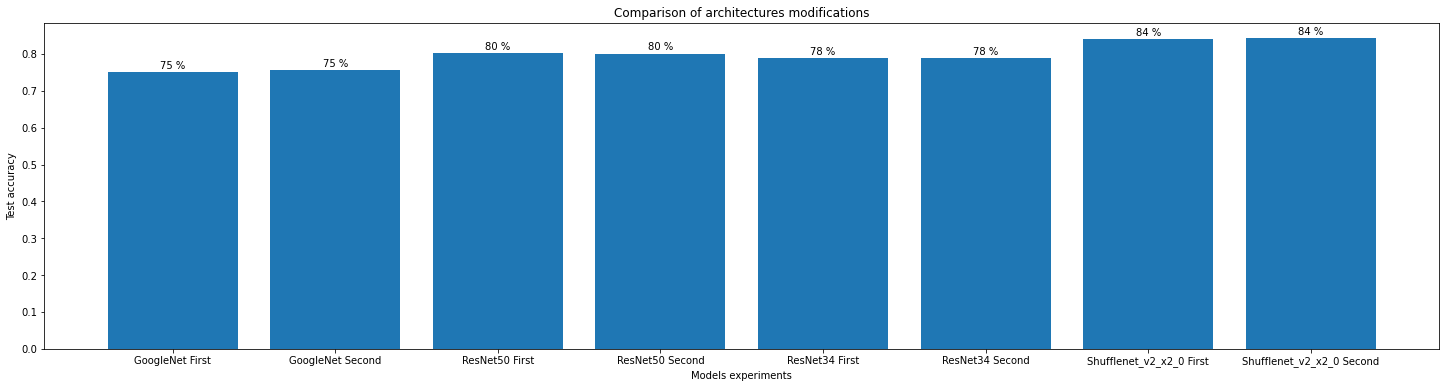

In [25]:
show_exp_result(acc_array, type_array)

In [31]:
acc_array

[tensor(0.7502),
 tensor(0.7526),
 tensor(0.8033),
 tensor(0.8159),
 tensor(0.7883),
 tensor(0.7886),
 tensor(0.8413),
 tensor(0.8457)]

In [32]:
type_array = ("GoogleNet First", "GoogleNet Second", "ResNet50 First", "ResNet50 Second", "ResNet34 First", "ResNet34 Second", "Shufflenet_v2_x2_0 First", "Shufflenet_v2_x2_0 Second")


{'GoogleNet First': tensor(0.7502), 'GoogleNet Second': tensor(0.7526), 'ResNet50 First': tensor(0.8033), 'ResNet50 Second': tensor(0.8159), 'ResNet34 First': tensor(0.7883), 'ResNet34 Second': tensor(0.7886), 'Shufflenet_v2_x2_0 First': tensor(0.8413), 'Shufflenet_v2_x2_0 Second': tensor(0.8457)}


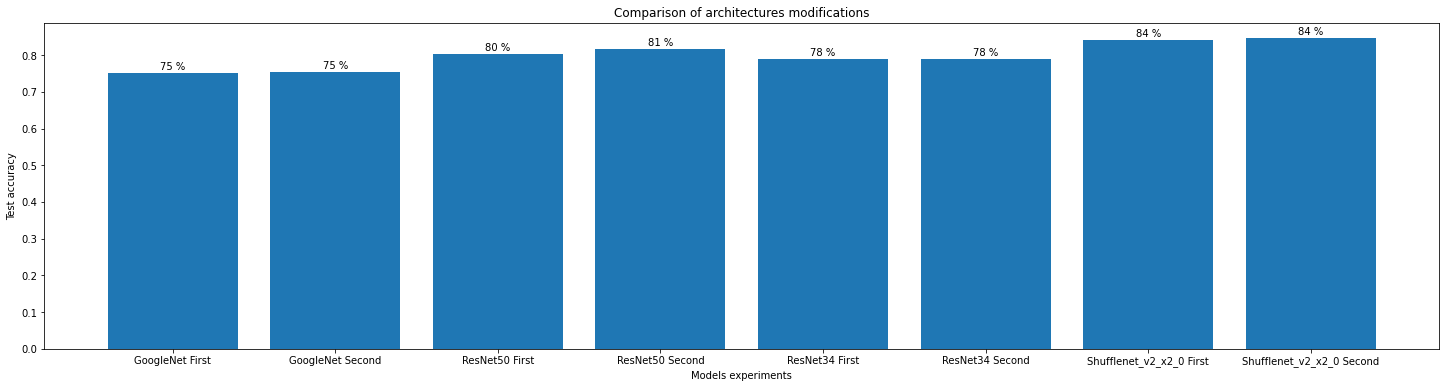

In [33]:
show_exp_result(acc_array, type_array)